In [1]:
import pennylane as qml
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

from pennylane import numpy as pnp

num_qubits = 2

In [2]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel

fake_backend = GenericBackendV2(num_qubits)
noise_model = NoiseModel.from_backend(fake_backend)

In [3]:
##############################################################################
# 1) Define devices:  noiseless ("default.qubit"),  noisy ("default.mixed").
##############################################################################

dev_exact = qml.device("default.qubit", wires = 2, shots = 1024)
# dev_noisy = qml.device(
#     "qiskit.aer",
#     wires=2,
#     shots=1024,
#     noise_model=noise_model  # The Qiskit noise model
# )
dev_noisy = qml.device("default.mixed", wires = 2, shots = 1024)

In [5]:
##############################################################################
# 2) Define the H2 Hamiltonian, the ansatz, and nuclear repulsion shift.
##############################################################################

# H2 Hamiltonian coefficients
coeffs = {
    'c0': -1.0523732,
    'c1':  0.39793742,
    'c2': -0.3979374,
    'c3': -0.0112801,
    'c4':  0.18093119
}
# Nuclear repulsion shift for H2 at R=0.75 A
nuclear_repulsion = 0.7199689944489797

coefs_list = [
    coeffs['c0'],
    coeffs['c1'],
    coeffs['c2'],
    coeffs['c3'],
    coeffs['c4']
]
ops_list = [
    qml.Identity(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliZ(0)   @ qml.Identity(1),
    qml.PauliZ(0)   @ qml.PauliZ(1),
    qml.PauliX(0)   @ qml.PauliX(1)
]
H = qml.Hamiltonian(coefs_list, ops_list)

In [ ]:
# ansatz with two parameters repeated to some "circuit_depth".
def ansatz(params, circuit_depth = 2, noisy = False):
    """
        applies RY-RZ layers plus CNOTs, optionally inserting amplitude & phase damping.
    """
    theta1, theta2 = params

    # initial single-qubit gates
    for w in range(2):
        qml.RY(theta1, wires=w)
        qml.RZ(theta1, wires=w)

    # optional noise
    if noisy:
        # amplitude & phase damping
        gamma = 0.1
        qml.AmplitudeDamping(gamma, wires=0)
        phi = 0.1
        qml.PhaseDamping(phi, wires=1)

    # repeated pattern: chain of CNOTs + single-qubit rotations
    for _ in range(circuit_depth):
        # CNOT in a chain [0->1]
        qml.CNOT(wires=[0,1])
        # single-qubit gates again
        for w in range(2):
            qml.RY(theta2, wires=w)
            qml.RZ(theta2, wires=w)

In [6]:
##############################################################################
# 3) define QNodes and cost functions for exact, noisy, and CDR runs.
##############################################################################

@qml.qnode(dev_exact)
def circuit_exact(params, circuit_depth=2):
    ansatz(params, circuit_depth=circuit_depth, noisy=False)
    return qml.expval(H)

@qml.qnode(dev_noisy)
def circuit_noisy(params, circuit_depth=2):
    ansatz(params, circuit_depth=circuit_depth, noisy=True)
    return qml.expval(H)

def cost_exact(params, circuit_depth=2):
    return circuit_exact(params, circuit_depth=circuit_depth) + nuclear_repulsion

def cost_noisy(params, circuit_depth=2):
    return circuit_noisy(params, circuit_depth=circuit_depth) + nuclear_repulsion


In [7]:
##############################################################################
# 4) define exact and noisy scipy return function. needs to be float
##############################################################################

def cost_exact_scipy(x):
    return float(cost_exact(x))

def cost_noisy_scipy(x):
    return float(cost_noisy(x))

In [8]:
##############################################################################
# 4) run minimization function for noisy and exact values
##############################################################################

from scipy.optimize import minimize

# initial guess of parameters (this gave best results)
init_params = np.array([pi/2, pi/2])  

# setup the callback for exact calculations
# append intermediate values for plotting
energy_history_exact = []
def callback_exact(xk, *args):
    val = cost_exact(xk)  # Evaluate cost
    energy_history_exact.append(val)

# runt he minimize function for multiple paramenters 
res_exact = minimize(cost_exact_scipy,
                     x0 = init_params,
                     method = "COBYLA",
                     callback = callback_exact,
                     options={"maxiter": 200, "disp": True})


   Normal return from subroutine COBYLA

   NFVALS =   28   F =-7.603226E-01    MAXCV = 0.000000E+00
   X = 2.186191E+00   1.320419E+00


In [9]:
# setup the callback for noisy calculations
# append intermediate values for plotting
energy_history_noisy = []
def callback_noisy(xk, *args):
    val = cost_noisy(xk)
    energy_history_noisy.append(val)

# run the minimize function for multiple paramenters 
res_noisy = minimize(cost_noisy_scipy,
                     x0=init_params,
                     method="COBYLA",
                     callback = callback_noisy,
                     options={"maxiter": 200, "disp": True})


   Normal return from subroutine COBYLA

   NFVALS =   31   F =-5.616613E-01    MAXCV = 0.000000E+00
   X = 2.616489E+00   1.093403E+00


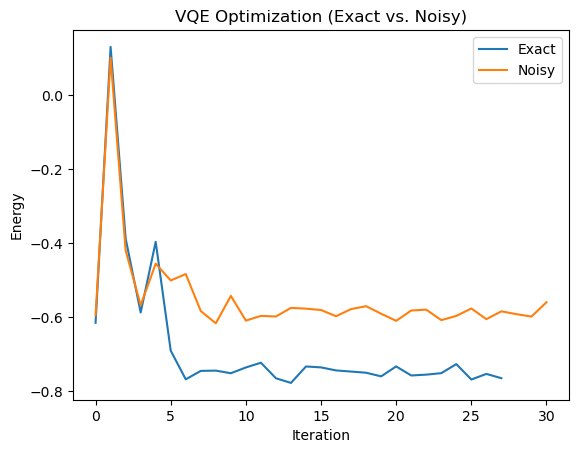

In [10]:
import matplotlib.pyplot as plt

plt.plot(energy_history_exact, label="Exact")
plt.plot(energy_history_noisy, label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Optimization (Exact vs. Noisy)")
plt.legend()
plt.show()

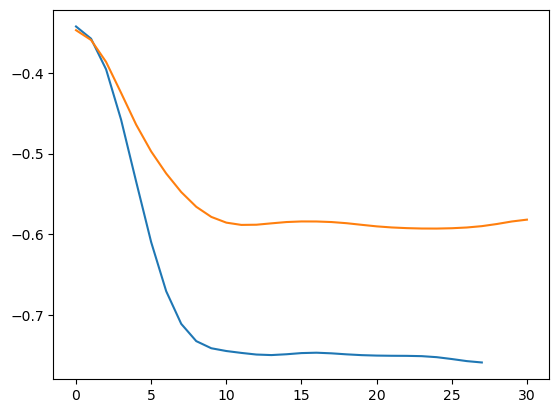

In [14]:
from scipy.ndimage import gaussian_filter1d

ysmoothed_exact = gaussian_filter1d(energy_history_exact, sigma=2)
ysmoothed_noisy = gaussian_filter1d(energy_history_noisy, sigma=2)
plt.plot(ysmoothed_exact)
plt.plot(ysmoothed_noisy)
plt.show()